In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

---
# Preparing Data
- Collects filename from the UCF directory for the selected 15 classes
- Using GroupShuffleSplit to ensure group level exclusion
- Uses GroupShuffleSplit on primary dataset to generate 1 random fold which becomes our train_main & test_main splits
- Uses GroupShuffleSplit on train_main dataset to generate 3 random folds for 3-fold crossvalidation hyperparameter tuning
---

In [2]:
from pathlib import Path
import re
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

In [3]:
# Define classes and mapping
classes = [
    "ApplyEyeMakeup", "BrushingTeeth", "CuttingInKitchen",
    "BodyWeightSquats", "JumpingJack", "PushUps",
    "Haircut", "SalsaSpin", "HeadMassage",
    "PlayingGuitar", "PlayingViolin", "PlayingTabla",
    "Archery", "BaseballPitch", "BasketballDunk"
]
label_map = {cls: i for i, cls in enumerate(classes)}

# Build full DataFrame of (filepath, label, group)
ROOT_DIR = Path(r"E:\Swinburne University of Technology\2025 S1\COS80027\Assignments\Team Assignment\UCF-101")
records = []
for cls in classes:
    for fp in (ROOT_DIR/cls).glob("*.avi"):
        m = re.search(r"_g(\d+)_", fp.name)
        group = m.group(1) if m else None
        rel = fp.relative_to(ROOT_DIR).as_posix()
        records.append({"filepath": rel, "label": label_map[cls], "group": group})
df = pd.DataFrame(records)

# Outer 80:20 split → train_main, test_main
outer_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx_main, test_idx = next(outer_split.split(df, groups=df["group"]))
train_main = df.iloc[train_idx_main].reset_index(drop=True)
test_main  = df.iloc[test_idx].reset_index(drop=True)

# Print main split sizes
print(f"Total clips: {len(df)}")
print(f"Train main (80%): {len(train_main)}")
print(f"Test main  (20%): {len(test_main)}")

# Inner 3 × 80:20 splits on train_main → train_inner_fold{1–3}, val_inner_fold{1–3}
inner_split = GroupShuffleSplit(n_splits=3, test_size=0.2, random_state=42)
for fold, (train_idx_in, val_idx_in) in enumerate(inner_split.split(train_main, groups=train_main["group"]), start=1):
    train_inner = train_main.iloc[train_idx_in].reset_index(drop=True)
    val_inner   = train_main.iloc[val_idx_in].reset_index(drop=True)
    # Print inner fold sizes
    print(f"\nInner Fold {fold}:")
    print(f" Train inner (80% of train_main): {len(train_inner)}")
    print(f" Val   inner (20% of train_main): {len(val_inner)}")

Total clips: 1930
Train main (80%): 1542
Test main  (20%): 388

Inner Fold 1:
 Train inner (80% of train_main): 1235
 Val   inner (20% of train_main): 307

Inner Fold 2:
 Train inner (80% of train_main): 1230
 Val   inner (20% of train_main): 312

Inner Fold 3:
 Train inner (80% of train_main): 1240
 Val   inner (20% of train_main): 302


---
# Data Preprocessing
- Creates custom dataset with custom definitions
- Builds outer (train & test) and inner (train & validation) data loaders
---

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import cv2
import numpy as np
import torch.nn as nn
from torchvision.models.video import r2plus1d_18, mc3_18, r3d_18
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid
from copy import deepcopy

In [5]:
# Root Directory
ROOT_DIR = Path(r"E:\Swinburne University of Technology\2025 S1\COS80027\Assignments\Team Assignment\UCF-101")

# 5. UCFOpenCVDataset definition
IMG_H, IMG_W = 112, 112
CLIP_LEN     = 16
MEAN = np.array([0.45,0.45,0.45],dtype=np.float32).reshape(1,1,3)
STD  = np.array([0.225,0.225,0.225],dtype=np.float32).reshape(1,1,3)

class UCFOpenCVDataset(Dataset):
    def __init__(self, csv_file, root_dir, clip_len):
        df = pd.read_csv(csv_file)
        self.paths   = df['filepath'].tolist()
        self.labels  = df['label'].tolist()
        self.clip_len = clip_len
        self.root_dir = Path(root_dir)
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        full = self.root_dir/self.paths[idx]
        cap, frames = cv2.VideoCapture(str(full)), []
        while len(frames)<self.clip_len:
            ret,frame=cap.read()
            if not ret: break
            f=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
            f=cv2.resize(f,(IMG_W,IMG_H))
            frames.append(f.astype(np.float32)/255.0)
        cap.release()
        if not frames: raise RuntimeError(f"No frames: {full}")
        while len(frames)<self.clip_len: frames.append(frames[-1].copy())
        clip = np.stack(frames,0)
        clip = (clip-MEAN)/STD
        return torch.from_numpy(clip).permute(3,0,1,2), self.labels[idx]

# 6. Build & print loader sizes
def build_outer_loaders():
    tr_ds = UCFOpenCVDataset("train_main.csv", ROOT_DIR, CLIP_LEN)
    te_ds = UCFOpenCVDataset("test_main.csv",  ROOT_DIR, CLIP_LEN)
    print(f"Outer split: train_main={len(tr_ds)}, test_main={len(te_ds)}")
    return DataLoader(tr_ds, batch_size=4, shuffle=True), DataLoader(te_ds, batch_size=1, shuffle=False)

def build_inner_loaders(fold):
    tr_ds = UCFOpenCVDataset(f"train_inner_fold{fold}.csv", ROOT_DIR, CLIP_LEN)
    va_ds = UCFOpenCVDataset(f"val_inner_fold{fold}.csv",   ROOT_DIR, CLIP_LEN)
    print(f"Inner Fold {fold}: train_inner={len(tr_ds)}, val_inner={len(va_ds)}")
    return DataLoader(tr_ds, batch_size=4, shuffle=True), DataLoader(va_ds, batch_size=1, shuffle=False)

# Inspect sizes
outer_tr, outer_te = build_outer_loaders()
for f in [1,2,3]:
    build_inner_loaders(f)

Outer split: train_main=1542, test_main=388
Inner Fold 1: train_inner=1235, val_inner=307
Inner Fold 2: train_inner=1230, val_inner=312
Inner Fold 3: train_inner=1240, val_inner=302


---
# Training & Saving Model
- Loads 2 models with pretrained weights: mc3_18 & r3d_18
- r3d_18 is a 3D‐ResNet-18 network that applies full 3×3×3 convolutions throughout the stem and residual blocks, pretrained on Kinetics-400 dataset.
- mc3_18 replaces the very first 3D convolution in each block with a 2D spatial convolution followed by a 1D temporal convolution, reducing parameters while preserving spatiotemporal modeling capacity, pretrained on Kinetics-400 dataset.
- Trains models for 9 (3 lr, 3 wd) parameter configurations using ParameterGrid()
- Validates them on validation sets
- Prints best accuracy and stores best configurations & best model version on 3-fold CV
---

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0)}")

Using device: NVIDIA GeForce RTX 4060 Laptop GPU


In [7]:
# Hyperparameter tuning
param_grid = {"lr":[1e-3,1e-4,1e-5], "weight_decay":[0.0,1e-5,1e-4]}
NUM_EPOCHS=5
models_to_tune = ["mc3_18","r3d_18"]

def train_and_evaluate_return_model(model, train_loader, val_loader, lr, wd):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()
    best_acc, best_model = 0.0, None

    for epoch in range(1, NUM_EPOCHS + 1):
        # Training
        model.train()
        total_loss = 0.0
        for clips, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=False):
            clips, labels = clips.to(device), labels.to(device)
            optimizer.zero_grad()
            loss = criterion(model(clips), labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * clips.size(0)
        train_loss = total_loss / len(train_loader.dataset)

        # Compute train accuracy
        model.eval()
        train_preds, train_trues = [], []
        with torch.no_grad():
            for clips, labels in train_loader:
                out = model(clips.to(device))
                train_preds.extend(out.argmax(1).cpu().numpy())
                train_trues.extend(labels.numpy())
        train_acc = accuracy_score(train_trues, train_preds)

        # Compute val accuracy
        val_preds, val_trues = [], []
        with torch.no_grad():
            for clips, labels in val_loader:
                out = model(clips.to(device))
                val_preds.extend(out.argmax(1).cpu().numpy())
                val_trues.extend(labels.numpy())
        val_acc = accuracy_score(val_trues, val_preds)

        tqdm.write(
            f"  Epoch {epoch}/{NUM_EPOCHS}: "
            f"Train Loss={train_loss:.4f}, "
            f"Train Acc={train_acc:.4f}, "
            f"Val Acc={val_acc:.4f}"
        )

        if val_acc > best_acc:
            best_acc, best_model = val_acc, deepcopy(model)

    return best_model, best_acc

In [8]:
def get_pretrained_model(model_name, num_classes=15, pretrained=True):
    if model_name == "r3d_18":
        model = r3d_18(pretrained=pretrained)
    elif model_name == "mc3_18":
        model = mc3_18(pretrained=pretrained)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    # Replace the final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [9]:
# Tuning loop with model and config prints

best_models = {}
for m in models_to_tune:
    print(f"\n=== Tuning model: {m} ===")
    best_score, best_cfg, best_mod = 0.0, None, None

    for cfg in ParameterGrid(param_grid):
        # Print current hyperparameter configuration
        print(f"\n-- Testing config: lr={cfg['lr']}, weight_decay={cfg['weight_decay']} --")
        scores, mods = [], []

        for f in [1, 2, 3]:
            print(f" Fold {f}...")
            model = get_pretrained_model(m)
            tr, va = build_inner_loaders(f)
            fm, fa = train_and_evaluate_return_model(
                model, tr, va, cfg["lr"], cfg["weight_decay"]
            )
            print(f"  -> Fold {f} Val Acc: {fa:.4f}")
            scores.append(fa)
            mods.append(fm)

        mean_acc = sum(scores) / len(scores)
        print(f" Mean CV Acc for config: {mean_acc:.4f}")

        if mean_acc > best_score:
            best_score, best_cfg = mean_acc, cfg
            best_mod = mods[scores.index(max(scores))]

    best_models[m] = {"config": best_cfg, "score": best_score}
    torch.save(best_mod.state_dict(), f"best_{m}.pth")
    print(f"*** Best for {m}: {best_cfg}, Mean Acc: {best_score:.4f} ***")



=== Tuning model: mc3_18 ===

-- Testing config: lr=0.001, weight_decay=0.0 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.1328, Train Acc=0.4955, Val Acc=0.3876


  Epoch 2/5: Train Loss=1.4117, Train Acc=0.7449, Val Acc=0.4886


  Epoch 3/5: Train Loss=0.9581, Train Acc=0.8348, Val Acc=0.4951


  Epoch 4/5: Train Loss=0.6896, Train Acc=0.9093, Val Acc=0.5863


  Epoch 5/5: Train Loss=0.4977, Train Acc=0.9255, Val Acc=0.5472
  -> Fold 1 Val Acc: 0.5863
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.3924, Train Acc=0.3447, Val Acc=0.2596


  Epoch 2/5: Train Loss=1.9416, Train Acc=0.4008, Val Acc=0.3494


  Epoch 3/5: Train Loss=1.4396, Train Acc=0.5488, Val Acc=0.3494


  Epoch 4/5: Train Loss=1.0059, Train Acc=0.8472, Val Acc=0.5321


  Epoch 5/5: Train Loss=0.8049, Train Acc=0.8943, Val Acc=0.4936
  -> Fold 2 Val Acc: 0.5321
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.1353, Train Acc=0.4935, Val Acc=0.3079


  Epoch 2/5: Train Loss=1.3586, Train Acc=0.6266, Val Acc=0.2980


  Epoch 3/5: Train Loss=0.9819, Train Acc=0.7879, Val Acc=0.4172


  Epoch 4/5: Train Loss=0.6987, Train Acc=0.9194, Val Acc=0.5099


  Epoch 5/5: Train Loss=0.5463, Train Acc=0.8976, Val Acc=0.5795
  -> Fold 3 Val Acc: 0.5795
 Mean CV Acc for config: 0.5659

-- Testing config: lr=0.001, weight_decay=1e-05 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=1.7947, Train Acc=0.5773, Val Acc=0.4365


  Epoch 2/5: Train Loss=1.1635, Train Acc=0.8162, Val Acc=0.4951


  Epoch 3/5: Train Loss=0.7660, Train Acc=0.8972, Val Acc=0.4919


  Epoch 4/5: Train Loss=0.4868, Train Acc=0.9441, Val Acc=0.6384


  Epoch 5/5: Train Loss=0.5520, Train Acc=0.9263, Val Acc=0.5440
  -> Fold 1 Val Acc: 0.6384
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.1401, Train Acc=0.4756, Val Acc=0.2724


  Epoch 2/5: Train Loss=1.4983, Train Acc=0.6715, Val Acc=0.4776


  Epoch 3/5: Train Loss=1.0138, Train Acc=0.9154, Val Acc=0.5801


  Epoch 4/5: Train Loss=0.7212, Train Acc=0.9211, Val Acc=0.5641


  Epoch 5/5: Train Loss=0.5067, Train Acc=0.9268, Val Acc=0.4840
  -> Fold 2 Val Acc: 0.5801
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.5293, Train Acc=0.2226, Val Acc=0.1225


  Epoch 2/5: Train Loss=2.5789, Train Acc=0.0863, Val Acc=0.0596


  Epoch 3/5: Train Loss=2.3770, Train Acc=0.2484, Val Acc=0.2219


  Epoch 4/5: Train Loss=2.2155, Train Acc=0.3516, Val Acc=0.2616


  Epoch 5/5: Train Loss=2.0306, Train Acc=0.4556, Val Acc=0.3245
  -> Fold 3 Val Acc: 0.3245
 Mean CV Acc for config: 0.5144

-- Testing config: lr=0.001, weight_decay=0.0001 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.5667, Train Acc=0.2389, Val Acc=0.1922


  Epoch 2/5: Train Loss=2.3102, Train Acc=0.1846, Val Acc=0.1824


  Epoch 3/5: Train Loss=2.1530, Train Acc=0.3198, Val Acc=0.2606


  Epoch 4/5: Train Loss=2.0517, Train Acc=0.4032, Val Acc=0.3844


  Epoch 5/5: Train Loss=1.9051, Train Acc=0.4000, Val Acc=0.3029
  -> Fold 1 Val Acc: 0.3844
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.1543, Train Acc=0.5081, Val Acc=0.4391


  Epoch 2/5: Train Loss=1.5398, Train Acc=0.5886, Val Acc=0.5064


  Epoch 3/5: Train Loss=1.0790, Train Acc=0.7675, Val Acc=0.5288


  Epoch 4/5: Train Loss=0.8520, Train Acc=0.8805, Val Acc=0.5449


  Epoch 5/5: Train Loss=0.6243, Train Acc=0.9285, Val Acc=0.5160
  -> Fold 2 Val Acc: 0.5449
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.4218, Train Acc=0.4081, Val Acc=0.2649


  Epoch 2/5: Train Loss=1.8493, Train Acc=0.5484, Val Acc=0.3940


  Epoch 3/5: Train Loss=1.4458, Train Acc=0.6452, Val Acc=0.3808


  Epoch 4/5: Train Loss=1.1436, Train Acc=0.7710, Val Acc=0.4338


  Epoch 5/5: Train Loss=0.8807, Train Acc=0.8565, Val Acc=0.4603
  -> Fold 3 Val Acc: 0.4603
 Mean CV Acc for config: 0.4632

-- Testing config: lr=0.0001, weight_decay=0.0 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=0.7846, Train Acc=0.9976, Val Acc=0.8664


  Epoch 2/5: Train Loss=0.1695, Train Acc=0.9992, Val Acc=0.8599


  Epoch 3/5: Train Loss=0.1091, Train Acc=0.9992, Val Acc=0.8306


  Epoch 4/5: Train Loss=0.0947, Train Acc=0.9968, Val Acc=0.8664


  Epoch 5/5: Train Loss=0.1010, Train Acc=0.9968, Val Acc=0.8860
  -> Fold 1 Val Acc: 0.8860
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=0.9050, Train Acc=0.9935, Val Acc=0.9295


  Epoch 2/5: Train Loss=0.1759, Train Acc=1.0000, Val Acc=0.9135


  Epoch 3/5: Train Loss=0.1218, Train Acc=1.0000, Val Acc=0.8974


  Epoch 4/5: Train Loss=0.1067, Train Acc=1.0000, Val Acc=0.9038


  Epoch 5/5: Train Loss=0.0961, Train Acc=1.0000, Val Acc=0.8686
  -> Fold 2 Val Acc: 0.9295
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=0.8911, Train Acc=0.9960, Val Acc=0.9272


  Epoch 2/5: Train Loss=0.1939, Train Acc=1.0000, Val Acc=0.9437


  Epoch 3/5: Train Loss=0.1202, Train Acc=1.0000, Val Acc=0.9139


  Epoch 4/5: Train Loss=0.1002, Train Acc=0.9968, Val Acc=0.9338


  Epoch 5/5: Train Loss=0.1106, Train Acc=1.0000, Val Acc=0.8841
  -> Fold 3 Val Acc: 0.9437
 Mean CV Acc for config: 0.9197

-- Testing config: lr=0.0001, weight_decay=1e-05 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=0.8656, Train Acc=0.9976, Val Acc=0.8730


  Epoch 2/5: Train Loss=0.1852, Train Acc=1.0000, Val Acc=0.8860


  Epoch 3/5: Train Loss=0.1221, Train Acc=0.9976, Val Acc=0.9251


  Epoch 4/5: Train Loss=0.1163, Train Acc=0.9992, Val Acc=0.8371


  Epoch 5/5: Train Loss=0.1160, Train Acc=1.0000, Val Acc=0.9153
  -> Fold 1 Val Acc: 0.9251
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=0.8883, Train Acc=0.9984, Val Acc=0.9231


  Epoch 2/5: Train Loss=0.1925, Train Acc=0.9992, Val Acc=0.9135


  Epoch 3/5: Train Loss=0.1255, Train Acc=1.0000, Val Acc=0.9038


  Epoch 4/5: Train Loss=0.1191, Train Acc=1.0000, Val Acc=0.9231


  Epoch 5/5: Train Loss=0.1111, Train Acc=1.0000, Val Acc=0.9199
  -> Fold 2 Val Acc: 0.9231
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=0.8390, Train Acc=0.9968, Val Acc=0.9305


  Epoch 2/5: Train Loss=0.1899, Train Acc=1.0000, Val Acc=0.9238


  Epoch 3/5: Train Loss=0.1361, Train Acc=0.9984, Val Acc=0.8709


  Epoch 4/5: Train Loss=0.1167, Train Acc=1.0000, Val Acc=0.9007


  Epoch 5/5: Train Loss=0.0952, Train Acc=0.9992, Val Acc=0.9238
  -> Fold 3 Val Acc: 0.9305
 Mean CV Acc for config: 0.9262

-- Testing config: lr=0.0001, weight_decay=0.0001 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=0.8626, Train Acc=0.9984, Val Acc=0.8795


  Epoch 2/5: Train Loss=0.1865, Train Acc=1.0000, Val Acc=0.9316


  Epoch 3/5: Train Loss=0.1369, Train Acc=1.0000, Val Acc=0.8925


  Epoch 4/5: Train Loss=0.1090, Train Acc=0.9992, Val Acc=0.8599


  Epoch 5/5: Train Loss=0.1348, Train Acc=0.9992, Val Acc=0.8567
  -> Fold 1 Val Acc: 0.9316
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=0.9242, Train Acc=0.9992, Val Acc=0.9135


  Epoch 2/5: Train Loss=0.1870, Train Acc=1.0000, Val Acc=0.9038


  Epoch 3/5: Train Loss=0.1428, Train Acc=1.0000, Val Acc=0.9071


  Epoch 4/5: Train Loss=0.0858, Train Acc=1.0000, Val Acc=0.9038


  Epoch 5/5: Train Loss=0.0892, Train Acc=0.9992, Val Acc=0.8846
  -> Fold 2 Val Acc: 0.9135
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=0.8783, Train Acc=0.9992, Val Acc=0.9338


  Epoch 2/5: Train Loss=0.1848, Train Acc=0.9976, Val Acc=0.9205


  Epoch 3/5: Train Loss=0.1347, Train Acc=1.0000, Val Acc=0.9470


  Epoch 4/5: Train Loss=0.1163, Train Acc=0.9992, Val Acc=0.9238


  Epoch 5/5: Train Loss=0.0962, Train Acc=0.9992, Val Acc=0.9205
  -> Fold 3 Val Acc: 0.9470
 Mean CV Acc for config: 0.9307

-- Testing config: lr=1e-05, weight_decay=0.0 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.2840, Train Acc=0.8413, Val Acc=0.6254


  Epoch 2/5: Train Loss=1.3365, Train Acc=0.9887, Val Acc=0.8730


  Epoch 3/5: Train Loss=0.8693, Train Acc=0.9968, Val Acc=0.8697


  Epoch 4/5: Train Loss=0.5657, Train Acc=0.9984, Val Acc=0.8990


  Epoch 5/5: Train Loss=0.4243, Train Acc=0.9992, Val Acc=0.8925
  -> Fold 1 Val Acc: 0.8990
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.2927, Train Acc=0.8959, Val Acc=0.7853


  Epoch 2/5: Train Loss=1.4077, Train Acc=0.9537, Val Acc=0.8397


  Epoch 3/5: Train Loss=0.8946, Train Acc=0.9854, Val Acc=0.8974


  Epoch 4/5: Train Loss=0.6276, Train Acc=0.9967, Val Acc=0.9327


  Epoch 5/5: Train Loss=0.4677, Train Acc=0.9976, Val Acc=0.9327
  -> Fold 2 Val Acc: 0.9327
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.2698, Train Acc=0.9129, Val Acc=0.7219


  Epoch 2/5: Train Loss=1.3867, Train Acc=0.9806, Val Acc=0.8444


  Epoch 3/5: Train Loss=0.8990, Train Acc=0.9960, Val Acc=0.9073


  Epoch 4/5: Train Loss=0.6307, Train Acc=0.9976, Val Acc=0.9205


  Epoch 5/5: Train Loss=0.4444, Train Acc=0.9992, Val Acc=0.9172
  -> Fold 3 Val Acc: 0.9205
 Mean CV Acc for config: 0.9174

-- Testing config: lr=1e-05, weight_decay=1e-05 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.3054, Train Acc=0.8640, Val Acc=0.6678


  Epoch 2/5: Train Loss=1.4075, Train Acc=0.9579, Val Acc=0.8078


  Epoch 3/5: Train Loss=0.9077, Train Acc=0.9895, Val Acc=0.8762


  Epoch 4/5: Train Loss=0.6126, Train Acc=0.9951, Val Acc=0.9186


  Epoch 5/5: Train Loss=0.4479, Train Acc=0.9984, Val Acc=0.9088
  -> Fold 1 Val Acc: 0.9186
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.2761, Train Acc=0.8837, Val Acc=0.6763


  Epoch 2/5: Train Loss=1.3923, Train Acc=0.9659, Val Acc=0.8526


  Epoch 3/5: Train Loss=0.9180, Train Acc=0.9878, Val Acc=0.9071


  Epoch 4/5: Train Loss=0.6563, Train Acc=0.9959, Val Acc=0.9071


  Epoch 5/5: Train Loss=0.4763, Train Acc=0.9951, Val Acc=0.9167
  -> Fold 2 Val Acc: 0.9167
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.2699, Train Acc=0.8234, Val Acc=0.6325


  Epoch 2/5: Train Loss=1.3857, Train Acc=0.9661, Val Acc=0.8411


  Epoch 3/5: Train Loss=0.9194, Train Acc=0.9887, Val Acc=0.8907


  Epoch 4/5: Train Loss=0.6326, Train Acc=0.9960, Val Acc=0.8940


  Epoch 5/5: Train Loss=0.4564, Train Acc=0.9976, Val Acc=0.9106
  -> Fold 3 Val Acc: 0.9106
 Mean CV Acc for config: 0.9153

-- Testing config: lr=1e-05, weight_decay=0.0001 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.2622, Train Acc=0.9117, Val Acc=0.7264


  Epoch 2/5: Train Loss=1.3818, Train Acc=0.9741, Val Acc=0.8208


  Epoch 3/5: Train Loss=0.8812, Train Acc=0.9943, Val Acc=0.8664


  Epoch 4/5: Train Loss=0.6214, Train Acc=0.9984, Val Acc=0.8925


  Epoch 5/5: Train Loss=0.4404, Train Acc=0.9984, Val Acc=0.8990
  -> Fold 1 Val Acc: 0.8990
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.2816, Train Acc=0.8764, Val Acc=0.7372


  Epoch 2/5: Train Loss=1.4525, Train Acc=0.9740, Val Acc=0.8622


  Epoch 3/5: Train Loss=0.9889, Train Acc=0.9919, Val Acc=0.9199


  Epoch 4/5: Train Loss=0.6754, Train Acc=0.9976, Val Acc=0.9199


  Epoch 5/5: Train Loss=0.4902, Train Acc=0.9992, Val Acc=0.9295
  -> Fold 2 Val Acc: 0.9295
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.2888, Train Acc=0.8516, Val Acc=0.6954


  Epoch 2/5: Train Loss=1.4083, Train Acc=0.9774, Val Acc=0.8841


  Epoch 3/5: Train Loss=0.9097, Train Acc=0.9927, Val Acc=0.9272


  Epoch 4/5: Train Loss=0.6389, Train Acc=0.9960, Val Acc=0.9570


  Epoch 5/5: Train Loss=0.4557, Train Acc=0.9992, Val Acc=0.9636
  -> Fold 3 Val Acc: 0.9636
 Mean CV Acc for config: 0.9307
*** Best for mc3_18: {'lr': 1e-05, 'weight_decay': 0.0001}, Mean Acc: 0.9307 ***

=== Tuning model: r3d_18 ===

-- Testing config: lr=0.001, weight_decay=0.0 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.5901, Train Acc=0.2283, Val Acc=0.2443


  Epoch 2/5: Train Loss=2.1763, Train Acc=0.4154, Val Acc=0.3583


  Epoch 3/5: Train Loss=1.9226, Train Acc=0.4121, Val Acc=0.2704


  Epoch 4/5: Train Loss=1.5426, Train Acc=0.6769, Val Acc=0.3811


  Epoch 5/5: Train Loss=1.1990, Train Acc=0.7117, Val Acc=0.4495
  -> Fold 1 Val Acc: 0.4495
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.7918, Train Acc=0.1317, Val Acc=0.0769


  Epoch 2/5: Train Loss=2.6657, Train Acc=0.1268, Val Acc=0.1250


  Epoch 3/5: Train Loss=2.6038, Train Acc=0.2488, Val Acc=0.2019


  Epoch 4/5: Train Loss=2.4390, Train Acc=0.2967, Val Acc=0.2628


  Epoch 5/5: Train Loss=2.2607, Train Acc=0.3561, Val Acc=0.2788
  -> Fold 2 Val Acc: 0.2788
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.4665, Train Acc=0.1960, Val Acc=0.1887


  Epoch 2/5: Train Loss=1.9703, Train Acc=0.5581, Val Acc=0.3609


  Epoch 3/5: Train Loss=1.4569, Train Acc=0.7048, Val Acc=0.3907


  Epoch 4/5: Train Loss=1.0882, Train Acc=0.7903, Val Acc=0.4967


  Epoch 5/5: Train Loss=0.8390, Train Acc=0.8766, Val Acc=0.4768
  -> Fold 3 Val Acc: 0.4967
 Mean CV Acc for config: 0.4083

-- Testing config: lr=0.001, weight_decay=1e-05 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.6895, Train Acc=0.1854, Val Acc=0.1726


  Epoch 2/5: Train Loss=2.5810, Train Acc=0.1911, Val Acc=0.1726


  Epoch 3/5: Train Loss=2.3245, Train Acc=0.3457, Val Acc=0.2476


  Epoch 4/5: Train Loss=2.1512, Train Acc=0.3676, Val Acc=0.2997


  Epoch 5/5: Train Loss=1.9181, Train Acc=0.4842, Val Acc=0.3713
  -> Fold 1 Val Acc: 0.3713
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.6554, Train Acc=0.2309, Val Acc=0.2179


  Epoch 2/5: Train Loss=2.3336, Train Acc=0.3033, Val Acc=0.2019


  Epoch 3/5: Train Loss=1.9513, Train Acc=0.4585, Val Acc=0.3494


  Epoch 4/5: Train Loss=1.6882, Train Acc=0.6407, Val Acc=0.3750


  Epoch 5/5: Train Loss=1.3308, Train Acc=0.6829, Val Acc=0.4519
  -> Fold 2 Val Acc: 0.4519
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.7998, Train Acc=0.1097, Val Acc=0.0828


  Epoch 2/5: Train Loss=2.7343, Train Acc=0.0984, Val Acc=0.0795


  Epoch 3/5: Train Loss=2.6718, Train Acc=0.0984, Val Acc=0.0927


  Epoch 4/5: Train Loss=2.5693, Train Acc=0.1758, Val Acc=0.1722


  Epoch 5/5: Train Loss=2.4304, Train Acc=0.2492, Val Acc=0.2152
  -> Fold 3 Val Acc: 0.2152
 Mean CV Acc for config: 0.3462

-- Testing config: lr=0.001, weight_decay=0.0001 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.6785, Train Acc=0.1514, Val Acc=0.1759


  Epoch 2/5: Train Loss=2.4334, Train Acc=0.2202, Val Acc=0.1954


  Epoch 3/5: Train Loss=2.2211, Train Acc=0.4308, Val Acc=0.2736


  Epoch 4/5: Train Loss=1.9531, Train Acc=0.5053, Val Acc=0.3029


  Epoch 5/5: Train Loss=1.7386, Train Acc=0.5636, Val Acc=0.3355
  -> Fold 1 Val Acc: 0.3355
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.6096, Train Acc=0.2545, Val Acc=0.2019


  Epoch 2/5: Train Loss=2.3235, Train Acc=0.3065, Val Acc=0.2147


  Epoch 3/5: Train Loss=2.0653, Train Acc=0.3463, Val Acc=0.2244


  Epoch 4/5: Train Loss=1.8198, Train Acc=0.4748, Val Acc=0.3429


  Epoch 5/5: Train Loss=1.5573, Train Acc=0.6561, Val Acc=0.3622
  -> Fold 2 Val Acc: 0.3622
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.6247, Train Acc=0.2411, Val Acc=0.1788


  Epoch 2/5: Train Loss=2.3815, Train Acc=0.3282, Val Acc=0.2219


  Epoch 3/5: Train Loss=2.0885, Train Acc=0.4153, Val Acc=0.3046


  Epoch 4/5: Train Loss=1.8206, Train Acc=0.6395, Val Acc=0.3675


  Epoch 5/5: Train Loss=1.5695, Train Acc=0.6129, Val Acc=0.3079
  -> Fold 3 Val Acc: 0.3675
 Mean CV Acc for config: 0.3551

-- Testing config: lr=0.0001, weight_decay=0.0 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=0.7169, Train Acc=0.9935, Val Acc=0.9381


  Epoch 2/5: Train Loss=0.1997, Train Acc=0.9976, Val Acc=0.8893


  Epoch 3/5: Train Loss=0.1482, Train Acc=1.0000, Val Acc=0.8925


  Epoch 4/5: Train Loss=0.1221, Train Acc=0.9984, Val Acc=0.8925


  Epoch 5/5: Train Loss=0.0966, Train Acc=0.9984, Val Acc=0.8958
  -> Fold 1 Val Acc: 0.9381
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=0.7521, Train Acc=1.0000, Val Acc=0.9103


  Epoch 2/5: Train Loss=0.1591, Train Acc=0.9984, Val Acc=0.9391


  Epoch 3/5: Train Loss=0.1438, Train Acc=0.9959, Val Acc=0.9006


  Epoch 4/5: Train Loss=0.1557, Train Acc=0.9943, Val Acc=0.9071


  Epoch 5/5: Train Loss=0.1182, Train Acc=0.9951, Val Acc=0.9006
  -> Fold 2 Val Acc: 0.9391
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=0.7152, Train Acc=0.9984, Val Acc=0.9305


  Epoch 2/5: Train Loss=0.1889, Train Acc=0.9968, Val Acc=0.9371


  Epoch 3/5: Train Loss=0.1443, Train Acc=0.9992, Val Acc=0.9470


  Epoch 4/5: Train Loss=0.1343, Train Acc=0.9984, Val Acc=0.9106


  Epoch 5/5: Train Loss=0.0975, Train Acc=1.0000, Val Acc=0.9139
  -> Fold 3 Val Acc: 0.9470
 Mean CV Acc for config: 0.9414

-- Testing config: lr=0.0001, weight_decay=1e-05 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=0.7049, Train Acc=0.9951, Val Acc=0.9283


  Epoch 2/5: Train Loss=0.1667, Train Acc=0.9984, Val Acc=0.9023


  Epoch 3/5: Train Loss=0.1457, Train Acc=0.9992, Val Acc=0.8958


  Epoch 4/5: Train Loss=0.1677, Train Acc=0.9984, Val Acc=0.8502


  Epoch 5/5: Train Loss=0.1320, Train Acc=0.9984, Val Acc=0.9055
  -> Fold 1 Val Acc: 0.9283
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=0.7092, Train Acc=0.9984, Val Acc=0.9583


  Epoch 2/5: Train Loss=0.1579, Train Acc=0.9967, Val Acc=0.9359


  Epoch 3/5: Train Loss=0.1613, Train Acc=0.9959, Val Acc=0.9231


  Epoch 4/5: Train Loss=0.1378, Train Acc=0.9959, Val Acc=0.9295


  Epoch 5/5: Train Loss=0.1061, Train Acc=0.9976, Val Acc=0.9199
  -> Fold 2 Val Acc: 0.9583
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=0.7716, Train Acc=0.9976, Val Acc=0.9338


  Epoch 2/5: Train Loss=0.1859, Train Acc=0.9992, Val Acc=0.9106


  Epoch 3/5: Train Loss=0.1397, Train Acc=0.9968, Val Acc=0.8841


  Epoch 4/5: Train Loss=0.1295, Train Acc=0.9984, Val Acc=0.9172


  Epoch 5/5: Train Loss=0.1182, Train Acc=0.9984, Val Acc=0.9106
  -> Fold 3 Val Acc: 0.9338
 Mean CV Acc for config: 0.9401

-- Testing config: lr=0.0001, weight_decay=0.0001 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=0.7278, Train Acc=0.9992, Val Acc=0.9121


  Epoch 2/5: Train Loss=0.1904, Train Acc=1.0000, Val Acc=0.9088


  Epoch 3/5: Train Loss=0.1381, Train Acc=0.9976, Val Acc=0.8730


  Epoch 4/5: Train Loss=0.1283, Train Acc=0.9992, Val Acc=0.8795


  Epoch 5/5: Train Loss=0.0921, Train Acc=0.9960, Val Acc=0.8208
  -> Fold 1 Val Acc: 0.9121
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=0.7308, Train Acc=0.9967, Val Acc=0.9135


  Epoch 2/5: Train Loss=0.1622, Train Acc=0.9959, Val Acc=0.9103


  Epoch 3/5: Train Loss=0.1404, Train Acc=0.9976, Val Acc=0.9263


  Epoch 4/5: Train Loss=0.1186, Train Acc=0.9984, Val Acc=0.9038


  Epoch 5/5: Train Loss=0.1287, Train Acc=0.9919, Val Acc=0.8910
  -> Fold 2 Val Acc: 0.9263
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=0.7588, Train Acc=0.9968, Val Acc=0.9139


  Epoch 2/5: Train Loss=0.2044, Train Acc=0.9992, Val Acc=0.9338


  Epoch 3/5: Train Loss=0.1352, Train Acc=0.9960, Val Acc=0.9603


  Epoch 4/5: Train Loss=0.1472, Train Acc=0.9935, Val Acc=0.9073


  Epoch 5/5: Train Loss=0.1039, Train Acc=0.9952, Val Acc=0.9272
  -> Fold 3 Val Acc: 0.9603
 Mean CV Acc for config: 0.9329

-- Testing config: lr=1e-05, weight_decay=0.0 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.0560, Train Acc=0.9263, Val Acc=0.7622


  Epoch 2/5: Train Loss=1.0514, Train Acc=0.9919, Val Acc=0.8697


  Epoch 3/5: Train Loss=0.6120, Train Acc=0.9984, Val Acc=0.8893


  Epoch 4/5: Train Loss=0.3871, Train Acc=0.9992, Val Acc=0.9349


  Epoch 5/5: Train Loss=0.2747, Train Acc=1.0000, Val Acc=0.9446
  -> Fold 1 Val Acc: 0.9446
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.1221, Train Acc=0.9398, Val Acc=0.7436


  Epoch 2/5: Train Loss=1.1197, Train Acc=0.9846, Val Acc=0.9006


  Epoch 3/5: Train Loss=0.6739, Train Acc=0.9967, Val Acc=0.9295


  Epoch 4/5: Train Loss=0.4369, Train Acc=0.9992, Val Acc=0.9327


  Epoch 5/5: Train Loss=0.2870, Train Acc=1.0000, Val Acc=0.9455
  -> Fold 2 Val Acc: 0.9455
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.0671, Train Acc=0.9653, Val Acc=0.8311


  Epoch 2/5: Train Loss=1.0614, Train Acc=0.9952, Val Acc=0.9272


  Epoch 3/5: Train Loss=0.6084, Train Acc=0.9992, Val Acc=0.9371


  Epoch 4/5: Train Loss=0.4055, Train Acc=0.9992, Val Acc=0.9503


  Epoch 5/5: Train Loss=0.3051, Train Acc=1.0000, Val Acc=0.9570
  -> Fold 3 Val Acc: 0.9570
 Mean CV Acc for config: 0.9490

-- Testing config: lr=1e-05, weight_decay=1e-05 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=2.0569, Train Acc=0.9449, Val Acc=0.7980


  Epoch 2/5: Train Loss=1.0539, Train Acc=0.9870, Val Acc=0.8664


  Epoch 3/5: Train Loss=0.6481, Train Acc=0.9968, Val Acc=0.9121


  Epoch 4/5: Train Loss=0.4084, Train Acc=1.0000, Val Acc=0.9153


  Epoch 5/5: Train Loss=0.2790, Train Acc=1.0000, Val Acc=0.9055
  -> Fold 1 Val Acc: 0.9153
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.0918, Train Acc=0.9569, Val Acc=0.8750


  Epoch 2/5: Train Loss=1.0910, Train Acc=0.9935, Val Acc=0.9487


  Epoch 3/5: Train Loss=0.6363, Train Acc=0.9984, Val Acc=0.9359


  Epoch 4/5: Train Loss=0.4266, Train Acc=1.0000, Val Acc=0.9487


  Epoch 5/5: Train Loss=0.3144, Train Acc=1.0000, Val Acc=0.9455
  -> Fold 2 Val Acc: 0.9487
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.0873, Train Acc=0.9274, Val Acc=0.8212


  Epoch 2/5: Train Loss=1.0950, Train Acc=0.9839, Val Acc=0.9040


  Epoch 3/5: Train Loss=0.6419, Train Acc=0.9968, Val Acc=0.9470


  Epoch 4/5: Train Loss=0.4179, Train Acc=0.9992, Val Acc=0.9503


  Epoch 5/5: Train Loss=0.2891, Train Acc=1.0000, Val Acc=0.9570
  -> Fold 3 Val Acc: 0.9570
 Mean CV Acc for config: 0.9403

-- Testing config: lr=1e-05, weight_decay=0.0001 --
 Fold 1...
Inner Fold 1: train_inner=1235, val_inner=307


  Epoch 1/5: Train Loss=1.9880, Train Acc=0.9320, Val Acc=0.7915


  Epoch 2/5: Train Loss=1.0367, Train Acc=0.9927, Val Acc=0.9055


  Epoch 3/5: Train Loss=0.5880, Train Acc=0.9992, Val Acc=0.9316


  Epoch 4/5: Train Loss=0.4039, Train Acc=0.9992, Val Acc=0.9414


  Epoch 5/5: Train Loss=0.2596, Train Acc=1.0000, Val Acc=0.9283
  -> Fold 1 Val Acc: 0.9414
 Fold 2...
Inner Fold 2: train_inner=1230, val_inner=312


  Epoch 1/5: Train Loss=2.1680, Train Acc=0.9512, Val Acc=0.7692


  Epoch 2/5: Train Loss=1.1165, Train Acc=0.9927, Val Acc=0.9167


  Epoch 3/5: Train Loss=0.6415, Train Acc=0.9976, Val Acc=0.9423


  Epoch 4/5: Train Loss=0.4240, Train Acc=1.0000, Val Acc=0.9391


  Epoch 5/5: Train Loss=0.2759, Train Acc=1.0000, Val Acc=0.9423
  -> Fold 2 Val Acc: 0.9423
 Fold 3...
Inner Fold 3: train_inner=1240, val_inner=302


  Epoch 1/5: Train Loss=2.1261, Train Acc=0.9145, Val Acc=0.7815


  Epoch 2/5: Train Loss=1.0637, Train Acc=0.9911, Val Acc=0.9073


  Epoch 3/5: Train Loss=0.6569, Train Acc=0.9984, Val Acc=0.9536


  Epoch 4/5: Train Loss=0.4204, Train Acc=0.9992, Val Acc=0.9536


  Epoch 5/5: Train Loss=0.3069, Train Acc=1.0000, Val Acc=0.9735
  -> Fold 3 Val Acc: 0.9735
 Mean CV Acc for config: 0.9524
*** Best for r3d_18: {'lr': 1e-05, 'weight_decay': 0.0001}, Mean Acc: 0.9524 ***


---
# Evaluations
- Retrains both models using the best configurations on whole training set
- Stored training loss & accuracy scores per epoch
- Evaluates using testing set
- Plots training loss and accuracy graphs
- Plots confusion matrices
- Shows sample predictions
---

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


=== Retraining & Evaluating mc3_18 ===
Using best config: lr=1e-05, weight_decay=0.0001


Epoch 1: Loss=2.1803, Train Acc=0.9014


Epoch 2: Loss=1.2316, Train Acc=0.9682


Epoch 3: Loss=0.7711, Train Acc=0.9935


Epoch 4: Loss=0.5268, Train Acc=0.9955


Epoch 5: Loss=0.3600, Train Acc=0.9987


Testing Batches: 100%|██████████████████████████████| 388/388 [00:09<00:00, 42.50it/s]


Test Accuracy: 0.9665


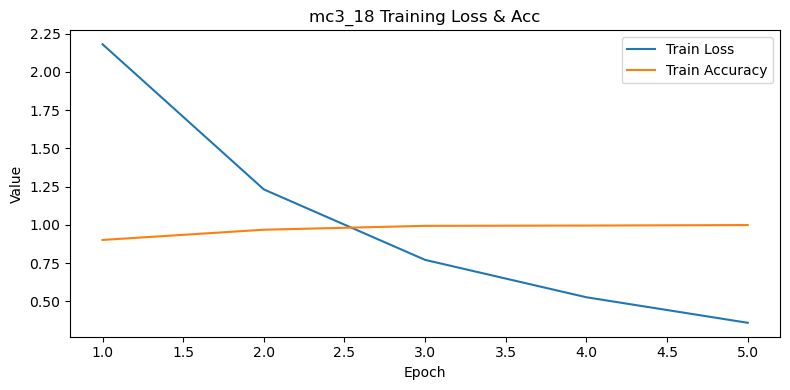

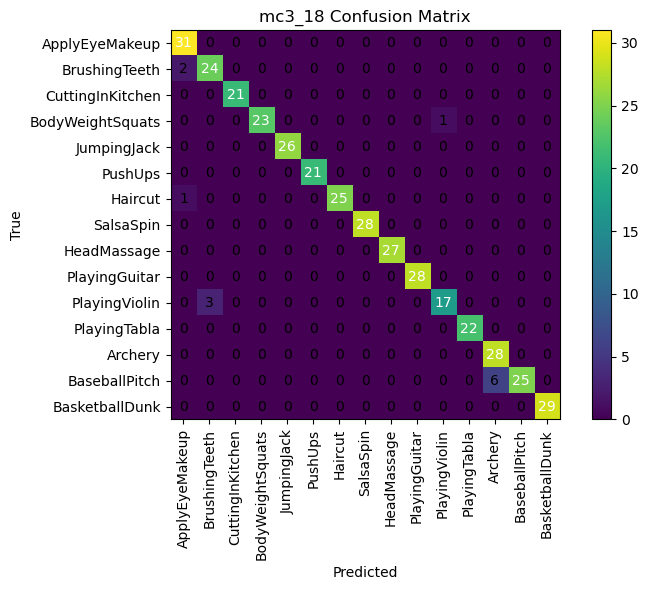


Sample predictions (mc3_18, lr=1e-05, wd=0.0001):


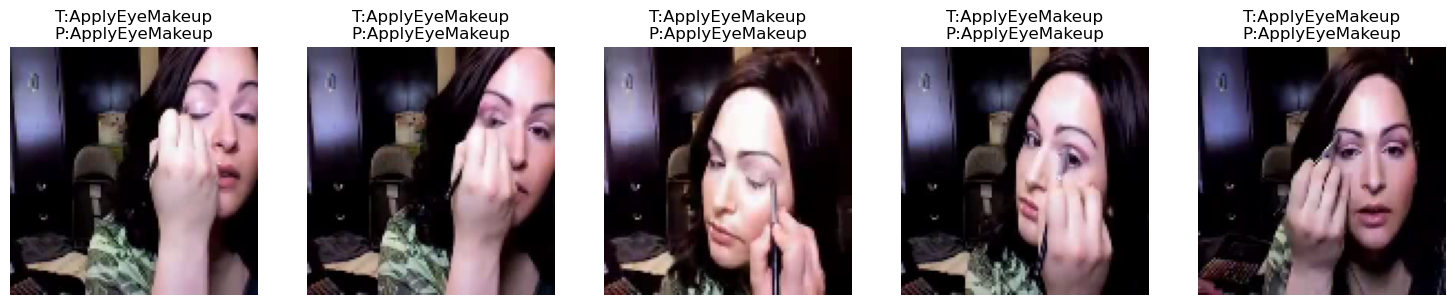


=== Retraining & Evaluating r3d_18 ===
Using best config: lr=1e-05, weight_decay=0.0001


Epoch 1: Loss=1.9909, Train Acc=0.9702


Epoch 2: Loss=0.9214, Train Acc=0.9942


Epoch 3: Loss=0.5321, Train Acc=0.9974


Epoch 4: Loss=0.3617, Train Acc=1.0000


Epoch 5: Loss=0.2507, Train Acc=1.0000


Testing Batches: 100%|██████████████████████████████| 388/388 [00:08<00:00, 44.54it/s]


Test Accuracy: 0.9691


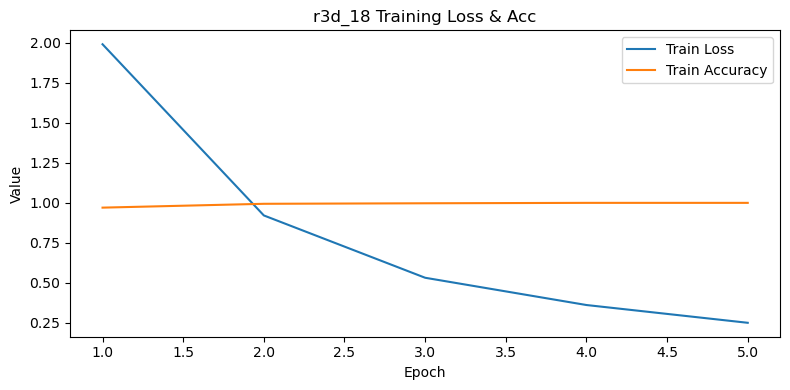

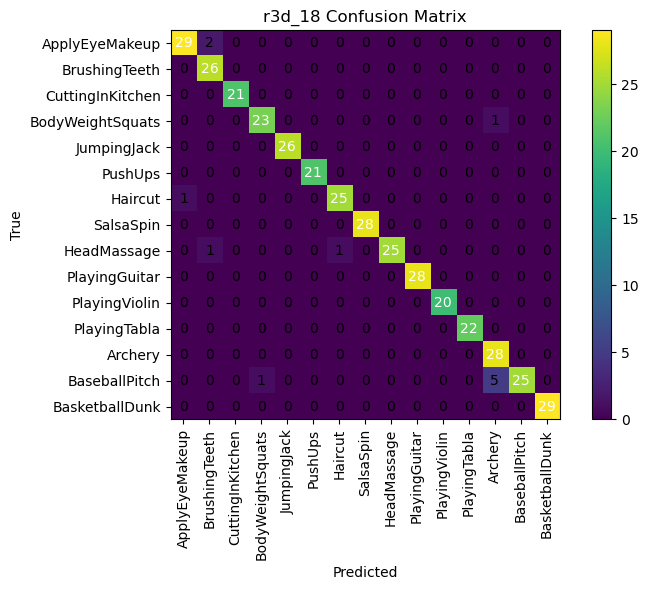


Sample predictions (r3d_18, lr=1e-05, wd=0.0001):


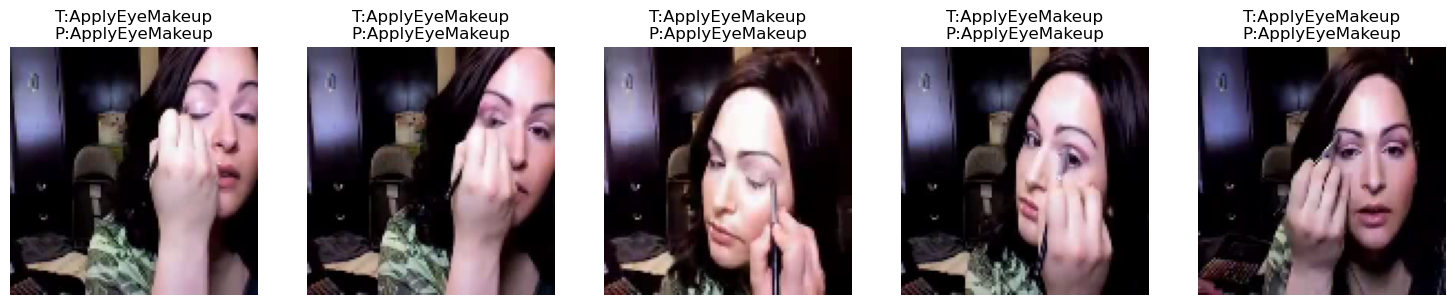

In [16]:
# Training on outer_tr, outer_te with the best hyperparameter configuration
for model_name, info in best_models.items():
    # Print header
    lr = info["config"]["lr"]
    wd = info["config"]["weight_decay"]
    print(f"\n=== Retraining & Evaluating {model_name} ===")
    print(f"Using best config: lr={lr}, weight_decay={wd}")

    # Prepare model, optimizer, loss
    model = get_pretrained_model(model_name)
    model.fc = nn.Linear(model.fc.in_features, len(classes))
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    train_accs   = []

    # Retrain model using best hyperparameter configurations
    for epoch in range(1, NUM_EPOCHS + 1):
        model.train()
        total_loss = 0.0
    
        for clips, labels in tqdm(outer_tr, desc=f"Epoch {epoch}", leave=False):
            clips, labels = clips.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(clips)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * clips.size(0)
    
        epoch_loss = total_loss / len(outer_tr.dataset)
        train_losses.append(epoch_loss)

        # Compute train accuracy
        model.eval()
        preds, trues = [], []
        with torch.no_grad():
            for clips, labels in outer_tr:
                out = model(clips.to(device))
                preds.extend(out.argmax(1).cpu().numpy())
                trues.extend(labels.numpy())
        epoch_acc = accuracy_score(trues, preds)
        train_accs.append(epoch_acc)

        print(f"Epoch {epoch}: Loss={epoch_loss:.4f}, Train Acc={epoch_acc:.4f}")

    # Evaluate on test set
    all_preds, all_labels = [], []
    model.eval()
    with torch.no_grad():
        for clips, labels in tqdm(outer_te, desc="Testing Batches"):
            out = model(clips.to(device))
            preds = out.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {test_acc:.4f}")

    # Plot training loss & accuracy
    epochs = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(8,4))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, train_accs,   label="Train Accuracy")
    plt.title(f"{model_name} Training Loss & Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{model_name} Confusion Matrix")
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=90)
    plt.yticks(ticks, classes)
    thresh = cm.max() / 2
    for r in range(cm.shape[0]):
        for c in range(cm.shape[1]):
            plt.text(c, r, cm[r, c],
                     ha="center", va="center",
                     color="white" if cm[r, c] > thresh else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Visualize sample predictions with model name and config
    print(f"\nSample predictions ({model_name}, lr={lr}, wd={wd}):")
    plt.figure(figsize=(15,3))
    for i in range(min(5, len(outer_te.dataset))):
        path = outer_te.dataset.paths[i]
        cap = cv2.VideoCapture(str(ROOT_DIR / path))
        ret, frame = cap.read()
        cap.release()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, (IMG_W, IMG_H))
        plt.subplot(1,5,i+1)
        plt.imshow(frame)
        true_lbl = classes[outer_te.dataset.labels[i]]
        pred_lbl = classes[all_preds[i]]
        plt.title(f"T:{true_lbl}\nP:{pred_lbl}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

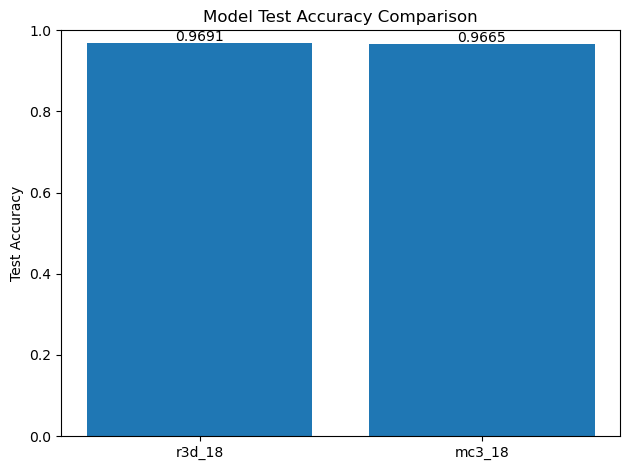

In [17]:
# Model names and their test accuracies
models = ['r3d_18', 'mc3_18']
accuracies = [0.9691, 0.9665]

# Bar chart for comparison
fig, ax = plt.subplots()
ax.bar(models, accuracies)
ax.set_ylim(0, 1)
ax.set_ylabel('Test Accuracy')
ax.set_title('Model Test Accuracy Comparison')
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.005, f"{acc:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Evaluation Results
---
- Model: r3d_18
    - Configurations:
        - Learning rate = 1e-05
        - Weight Decay = 0.0001
    - Accuracy: 96.91%
---
- Model: mc3_18
    - Configurations:
        - Learning rate = 1e-05
        - Weight Decay = 0.0001
    - Accuracy: 96.65%
---
## Best Model: _r3d_18_